In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the path to your dataset folder
data_dir = r"C:\Users\Anil PC\OneDrive\Desktop\final project\final project\Dataset\archive (1)\Training"

# Categories (classes)
categories = ["glioma_tumor", "meningioma_tumor", "No_tumor", "pituitary_tumor"]

# Initialize lists to store images and labels
data = []
labels = []

# Loop through each category
for category in categories:
    folder = os.path.join(data_dir, category)  # Path to category folder
    label = categories.index(category)  # Assign a numeric label (0, 1, 2, 3)
    
    for img_name in os.listdir(folder):  # Loop through all image files
        img_path = os.path.join(folder, img_name)  # Full image path
        try:
            # Load image and resize to 128x128 pixels
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            
            # Append image and label to lists
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Normalize pixel values (0-255) to (0-1)
data = data / 255.0

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(categories))

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Check the shape of the data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (2296, 128, 128, 3)
Testing data shape: (574, 128, 128, 3)


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model (without the top classification layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model that outputs the features from the base model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from training and testing sets
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Reshape features to be suitable for model input
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)



72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_features, y_train.argmax(axis=1))  # Use argmax to convert one-hot to labels

# Make predictions and evaluate
rf_predictions = rf_model.predict(X_test_features)
rf_accuracy = accuracy_score(y_test.argmax(axis=1), rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.8432055749128919


In [5]:
from xgboost import XGBClassifier

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train_features, y_train.argmax(axis=1))

# Make predictions and evaluate
xgb_predictions = xgb_model.predict(X_test_features)
xgb_accuracy = accuracy_score(y_test.argmax(axis=1), xgb_predictions)

print(f"XGBoost Accuracy: {xgb_accuracy}")


XGBoost Accuracy: 0.8797909407665505


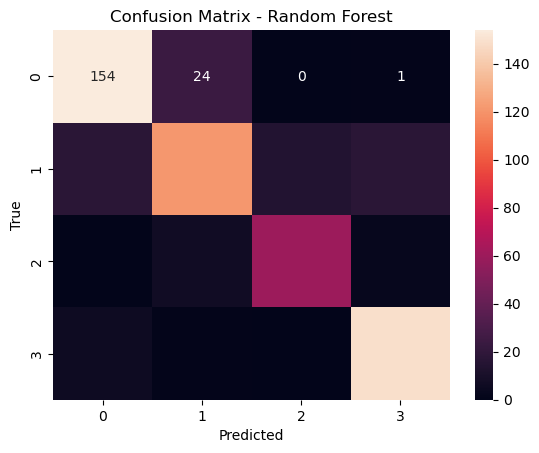

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       179
           1       0.79      0.72      0.75       169
           2       0.81      0.86      0.83        70
           3       0.88      0.96      0.91       156

    accuracy                           0.84       574
   macro avg       0.84      0.85      0.84       574
weighted avg       0.84      0.84      0.84       574



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test.argmax(axis=1), rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report for Random Forest
print(classification_report(y_test.argmax(axis=1), rf_predictions))


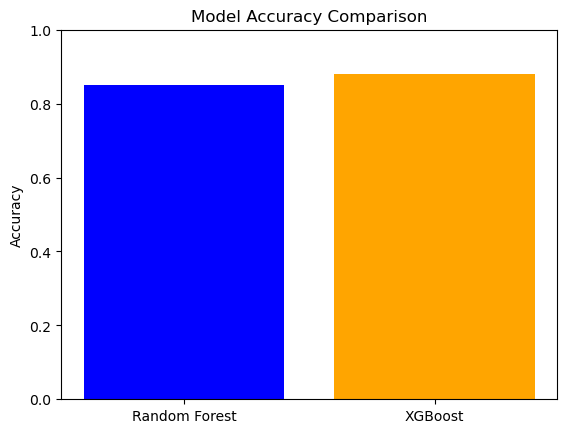

In [7]:
import matplotlib.pyplot as plt

# Example accuracies
rf_accuracy = 0.85
xgb_accuracy = 0.88

# Plot the model accuracy comparison
model_accuracy = {"Random Forest": rf_accuracy, "XGBoost": xgb_accuracy}
plt.bar(model_accuracy.keys(), model_accuracy.values(), color=['blue', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylim([0, 1])  # Accuracy ranges between 0 and 1
plt.ylabel("Accuracy")
plt.show()


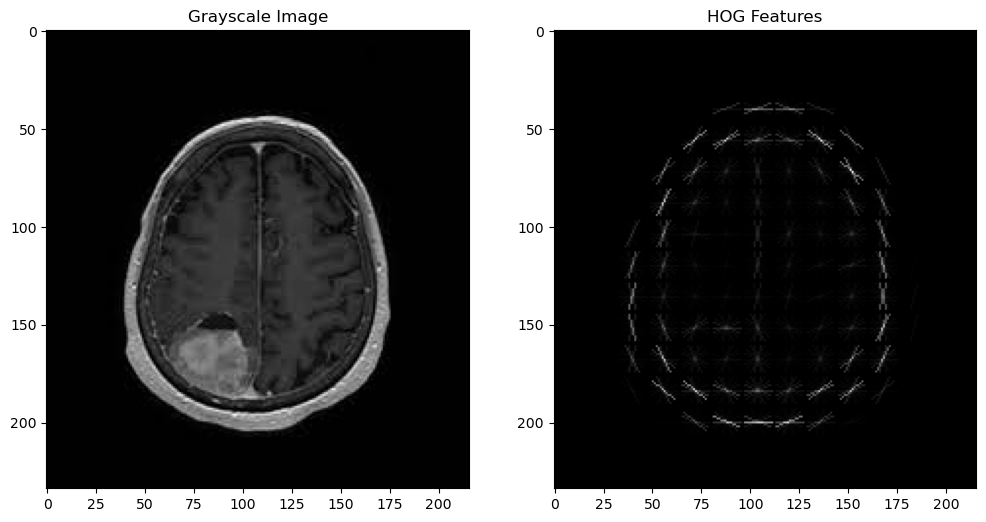

In [8]:
from skimage.feature import hog
import cv2

# Load and preprocess an example image
img_path = "C:/Users/Anil PC/Downloads/images.jpg"
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Extract HOG features and visualize
features, hog_image = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

# Plot the original and HOG feature image
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale Image")

# HOG feature image
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")

plt.show()


In [15]:
import gradio as gr

# Define prediction function
def predict(image):
    image = cv2.resize(image, (128, 128)) / 255.0  # Preprocess the input image
    features = feature_extractor.predict(np.expand_dims(image, axis=0))
    features = features.reshape(1, -1)  # Reshape for prediction
    prediction = rf_model.predict(features)  # Use Random Forest for prediction
    return categories[prediction[0]]

# Build the interface using Gradio
interface = gr.Interface(fn=predict, inputs="image", outputs="text", live=True)
interface.launch()


Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Traceback (most recent call last):
  File "D:\New folder\Lib\site-packages\gradio\queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\New folder\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\New folder\Lib\site-packages\gradio\blocks.py", line 1935, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\New folder\Lib\site-packages\gradio\blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\New folder\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
